# Import Libraries

In [1]:
import numpy as np # numpy used for numerical calculations
import pandas as pd # pandas used for anything data related
import matplotlib.pyplot as plt # matplotlib used for plotting
import seaborn as sns # seaborn used for plotting
import torch # pytorch used for neural networks
import torch.nn as nn # neural networks module in pytorch
import torch.optim as optim # optimization module in pytorch 
from sklearn.model_selection import KFold, StratifiedKFold # KFold used for cross validation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve # metrics used for evaluation

# EDA and Preprocessing

In [2]:
df = pd.read_csv('diabetes.csv') # read the csv file into a pandas dataframe
df.head() # display the first 5 rows of the pandas dataframe

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The following information regarding the features has been given on Kaggle:

1. Pregnancies: Number of times pregnant  
2. Glucose: Plasma glucose concentration in a 2 hours oral glucose tolerance test  
3. BloodPressure: Diastolic blood pressure (mm Hg)  
4. SkinThickness: Triceps skin fold thickness (mm)  
5. Insulin: 2-Hour serum insulin (mu U/ml)  
6. BMI: Body mass index (weight in kg/(height in m)^2)  
7. DiabetesPedigreeFunction: Diabetes pedigree function  
8. Age: Age (Years)  
9. Outcome: Class variable (0 represents no diabetes and 1 otherwise)

Right of the bat, I can notice that the dataset doesn't follow the tame conventions of data. I'll convert the feature names in snake_case and make sure that no feature name is longer than 20 characters. Note that for any operation, I'm not using inplace=True argument just for better flow while coding.

In [3]:
df = df.rename(columns={"Pregnancies": "pregnancies", "Glucose": "glucose", "BloodPressure": "blood_pressure", 
                        "SkinThickness": "skin_thickness", "Insulin": "insulin", "BMI": "bmi", "DiabetesPedigreeFunction": "diabetes_pedigree", 
                        "Age": "age", "Outcome": "outcome"}) # rename dataframe columns according to tame data conventions
df.columns # display the new feature names

Index(['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin',
       'bmi', 'diabetes_pedigree', 'age', 'outcome'],
      dtype='object')

In [7]:
df.info() # display information regarding features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        768 non-null    int64  
 1   glucose            768 non-null    int64  
 2   blood_pressure     768 non-null    int64  
 3   skin_thickness     768 non-null    int64  
 4   insulin            768 non-null    int64  
 5   bmi                768 non-null    float64
 6   diabetes_pedigree  768 non-null    float64
 7   age                768 non-null    int64  
 8   outcome            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


From the dataset info, we can see that all the features are of right data type. Only bmi and diabetes_pedigree can take decimal values so they are float. Our target is a categorical variable (there are more categorical variables in the dataset) and in Python, we'll just use int64 for them. Let's move on to EDA now.

In [8]:
df.describe() # display summary statistics for numerical features (I'm not looking at categorical features over here)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The minimum value for glucose, blood_pressue, skin_thickness, insulin and bmi cannot be 0. Any 0 value in these features indicates a missing value. So let's remove the rows with missing values. 

In [9]:
for column in ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']: # iterate through numerical features
    df.drop(df[df[column] == 0].index, inplace=True) # drop rows with 0 values 

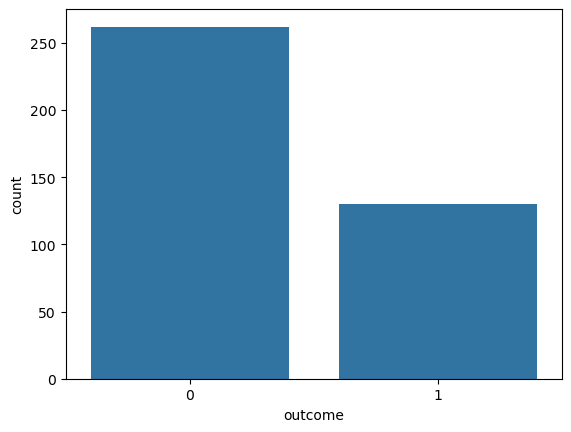

In [10]:
sns.countplot(x='outcome', data=df) # plot the count of each class in the outcome feature
plt.show() # display the plot

Our dataset is imbalanced. I don't want to create new data points by undersampling or oversampling using SMOTE because I'm not a big fan of it. I'll keep the dataset as it is and instead use the F1 Score as my metric to measure the performance. Let's look at the pregnancies feature since it's the only categorical feature (age can be considered categorical but that's a lot of categories. It is better to consider it numerical).

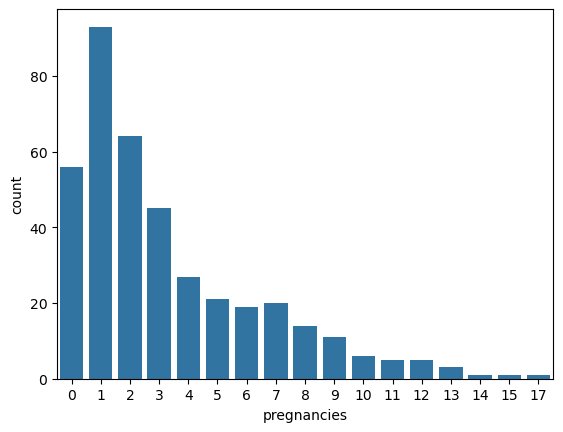

In [11]:
sns.countplot(x="pregnancies", data=df) # plot the count of each class in the pregnancies feature
plt.show() # display the plot

There are 18 different categories in pregnancies. This makes me think should I consider it a categorical or numerical feature? Since all the other features are numerical and I'll standardise them, I'll consider this feature as a numerical feature to maintain the consistency of features.

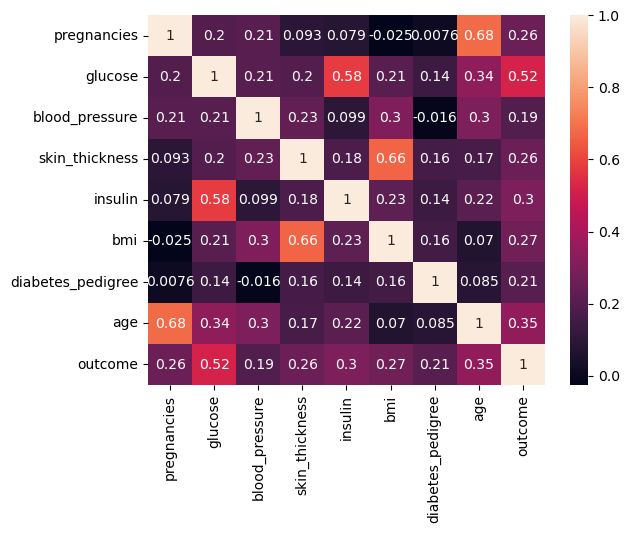

In [12]:
corr_matrix = df.corr() # get the correlation matrix using kendall method since it is more robust and does not take any assumptions about the data
sns.heatmap(corr_matrix, annot=True) # plot the heatmap using the correlation matrix with annotations
plt.show() # display the plot

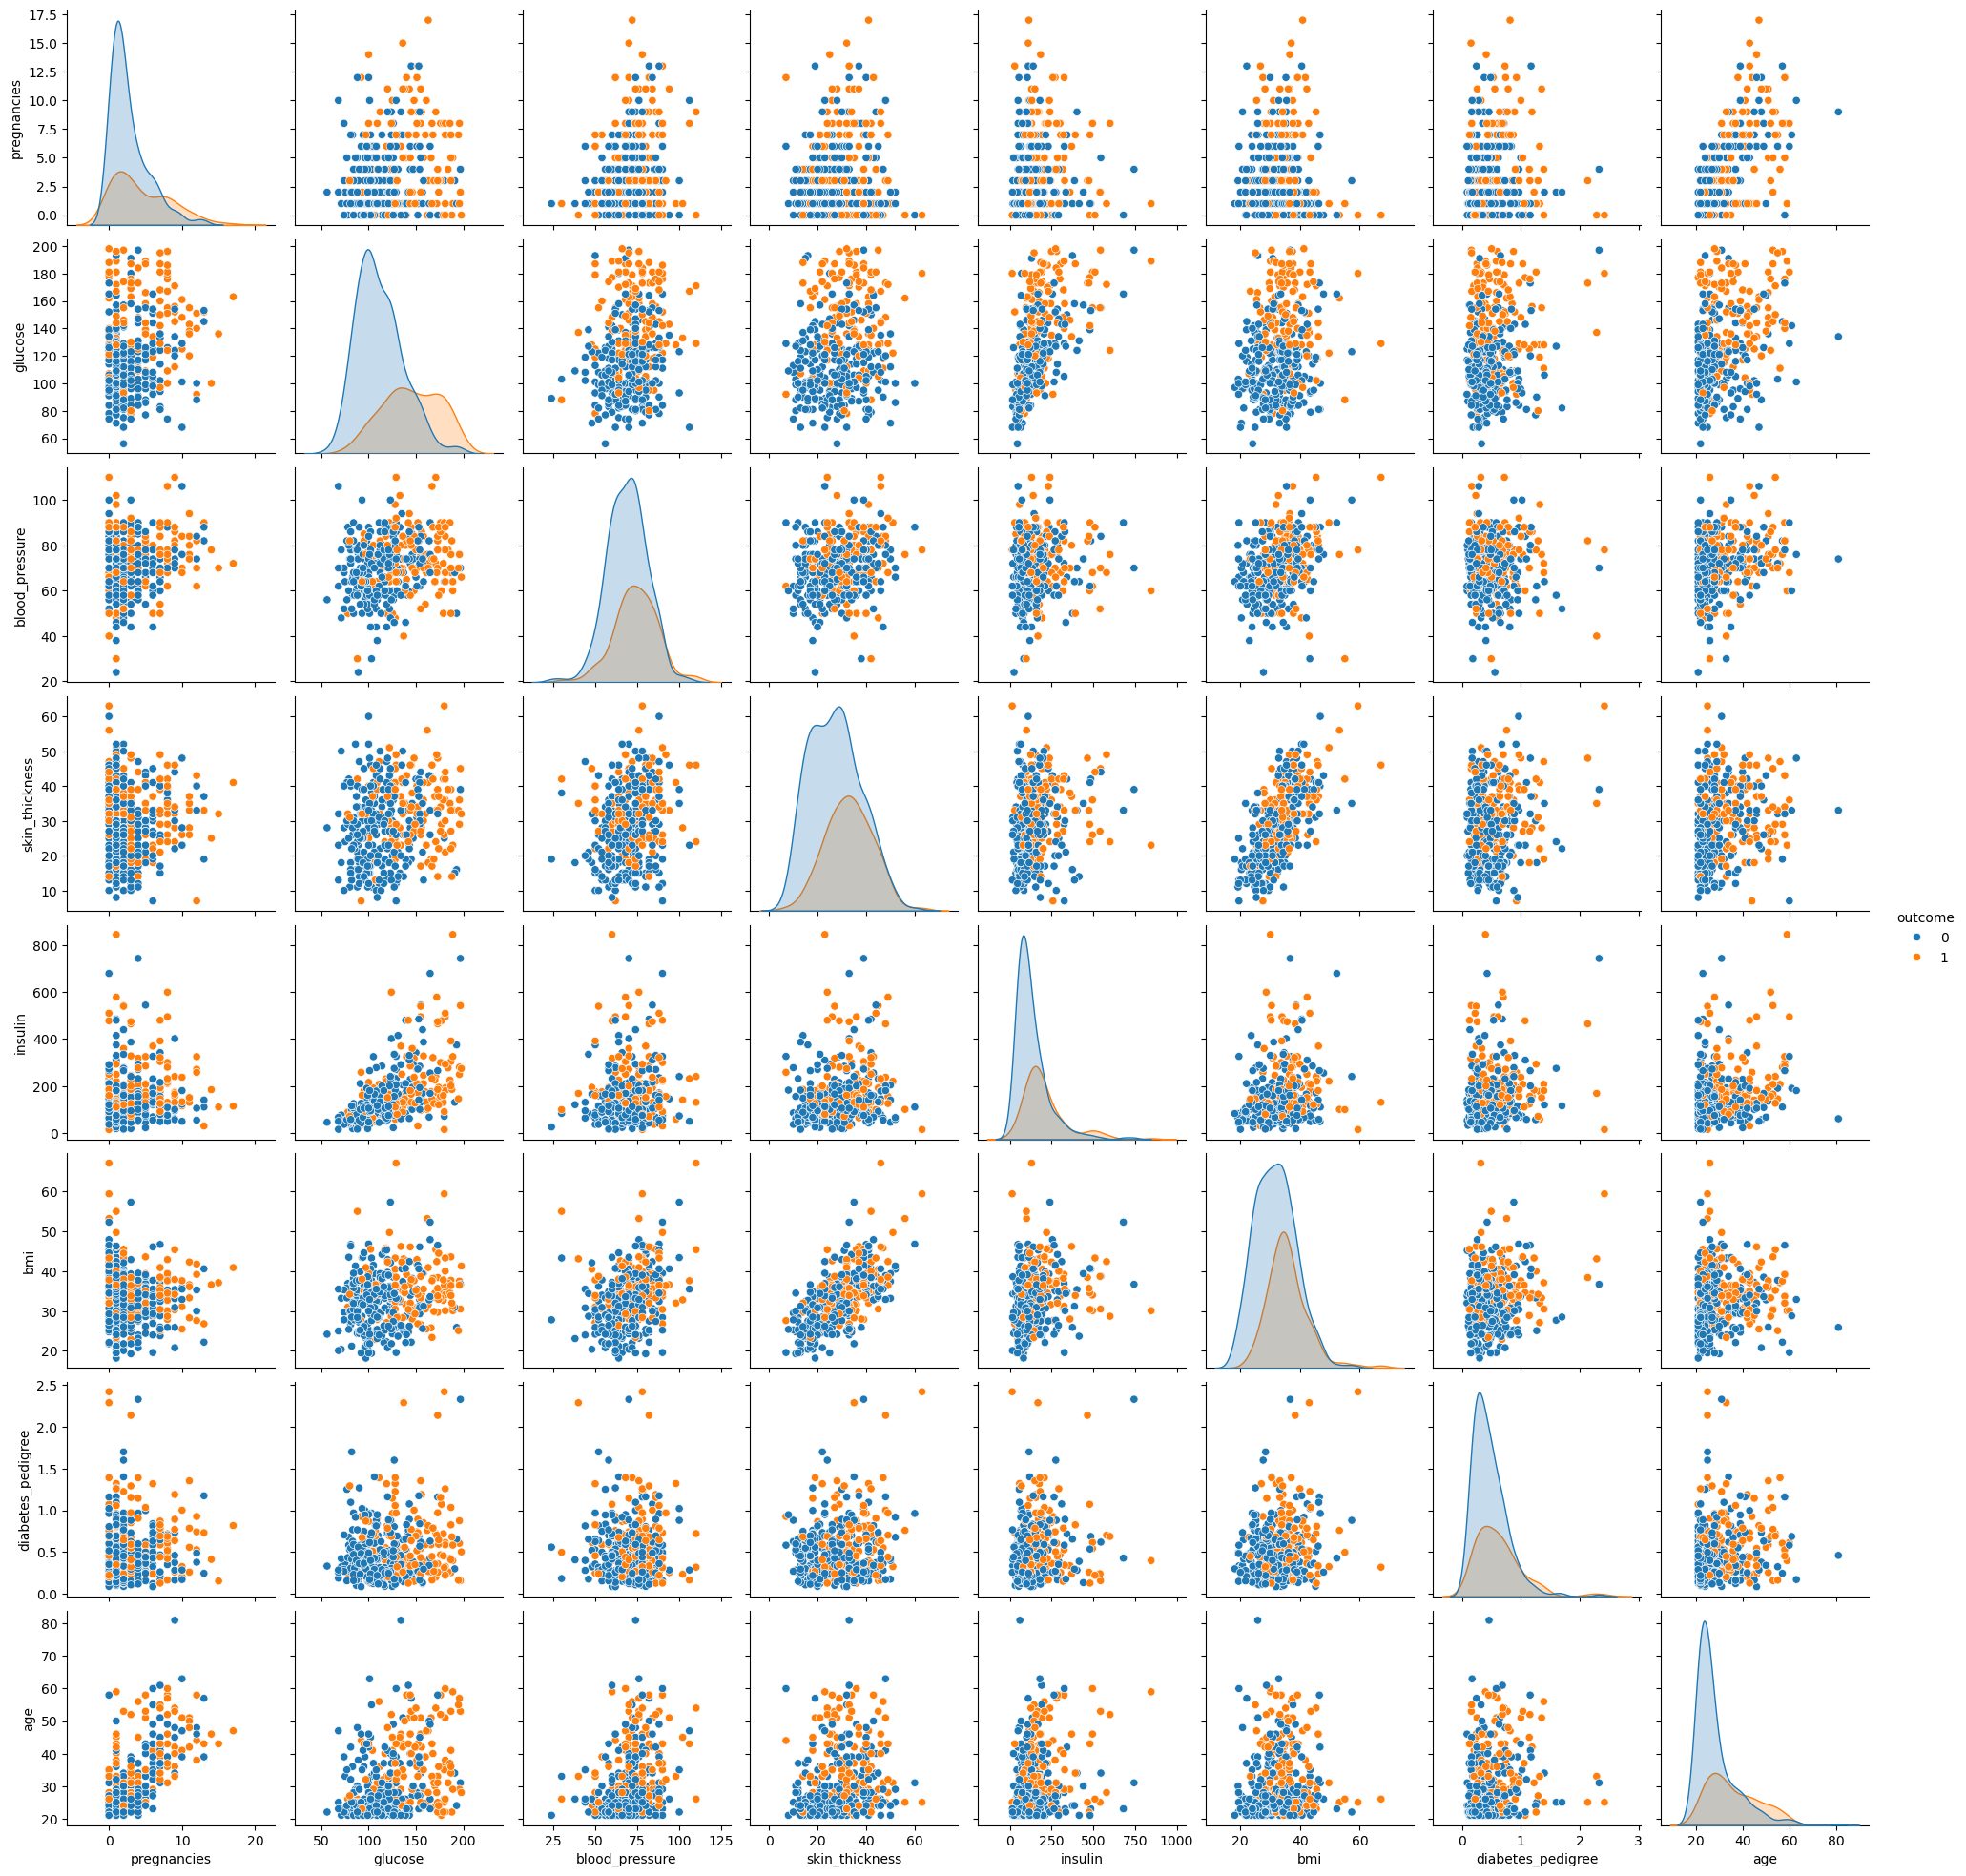

In [13]:
sns.pairplot(df, hue='outcome') # plot the pairplot to get different scatter plots for each pair of features and kernel density estimates for all features
plt.show() # display the plot

No two features seem highly correlated which is a good thing. Glucose has the best correlation with outcome which is visible from the correlation matrix and the kernel density estimate. I'll be selecting all the features for my perceptron model. Before I start modelling, I'll standardise the features for better computation and to avoid larger weight values for particular features.

In [14]:
X_columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age'] # define the feature columns
for column in X_columns: # iterate through the feature columns
    df[column] = (df[column] - df[column].mean()) / df[column].std() # standardize the feature columns

df.head() # display the first 5 rows of the dataframe to see standardized data

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
3,-0.716511,-1.089653,-0.373178,-0.584363,-0.522175,-0.709514,-1.030559,-0.967063,0
4,-1.027899,0.465719,-2.453828,0.556709,0.100502,1.424909,5.108582,0.209318,1
6,-0.093734,-1.446093,-1.653578,0.271441,-0.572662,-0.296859,-0.796108,-0.476904,1
8,-0.405123,2.409934,-0.053078,1.507603,3.255961,-0.368007,-1.056609,2.169953,1
13,-0.716511,2.150705,-0.853328,-0.584363,5.805571,-0.424924,-0.361940,2.758143,1


# Modelling using Perceptron

For modelling, I'll be using a perceptron with the Adam Optimizer, coded using pytorch. I'll also do K-Fold Cross Validation to make sure that the model performs well for all kinds of split, i.e., it generalises well. At first, I'll start with a less complex model (a single layered perceptron) and then a more complex multi-layered perceptron. Note that an MLP only has a single hidden layer. An Artificial Neural Network (ANN) has multiple hidden layers and I've experimented with that as well.

Note: To run the stratify experiment, simply set the stratify variable to True.

## Perceptron

Fold 1/5
Fold 1: Accuracy=0.7468, Precision=0.6071428571428571, Recall=0.6538, F1=0.6296, AUROC=0.8360
Fold 2/5
Fold 2: Accuracy=0.7468, Precision=0.6363636363636364, Recall=0.5385, F1=0.5833, AUROC=0.8665
Fold 3/5
Fold 3: Accuracy=0.8205, Precision=0.7307692307692307, Recall=0.7308, F1=0.7308, AUROC=0.8854
Fold 4/5
Fold 4: Accuracy=0.7436, Precision=0.5833333333333334, Recall=0.8077, F1=0.6774, AUROC=0.8654
Fold 5/5
Fold 5: Accuracy=0.7179, Precision=0.5666666666666667, Recall=0.6538, F1=0.6071, AUROC=0.8107

Average Validation Metrics:
Accuracy: 0.7551
Precision: 0.6249
Recall: 0.6769
F1 Score: 0.6457
AUROC: 0.8528


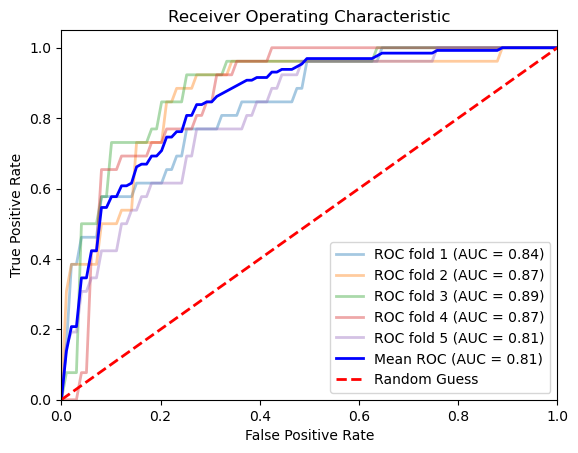

In [15]:
np.random.seed(42) # define the seed for reproducibility
torch.manual_seed(42) # define the seed for reproducibility

n_splits = 5 # define the number of splits for cross validation
stratify = False # define whether to stratify the splits or not
if stratify: 
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # define the StratifiedKFold cross validation object
else:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # define the KFold cross validation object
'''KFold will split the data based on the number of splits and shuffle the data before splitting. Once the splits are done,
will consider each split as a validation set and the rest as the training set. So basically, the model will be trained on different training
sets n_splits times. Considering the average performance of all validation sets will give a better estimate of the model's performance.'''

# define empty lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
aurocs = []
fprs = []
tprs = []
mean_fpr = np.linspace(0, 1, 100) # define the mean false positive rate values to be used for the roc curve

class Perceptron(nn.Module):
    '''
    class: Basic perceptron
    '''
    def __init__(self, input_dim):
        '''
        function: initialize the perceptron class 
        input_dim: number of input features
        self.fc = fully connected layer with input_dim input features and 1 output feature
        '''
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        '''
        function: forward pass
        returns: sigmoid of the fully connected layer
        '''
        return torch.sigmoid(self.fc(x))

X = df.drop(columns=['outcome']).values # extract the feature values from the dataframe. This is a numpy array.
y = df['outcome'].values # extract the target values from the dataframe. This is again a numpy array.

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y) if stratify else kf.split(X)): # iterate through the splits
    print(f"Fold {fold+1}/{n_splits}")

    X_train, X_val = X[train_idx], X[val_idx] # get the training and validation features
    y_train, y_val = y[train_idx], y[val_idx] # get the training and validation targets

    X_train = torch.tensor(X_train, dtype=torch.float32) # converting training features into tensors for modelling
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # converting training targets into tensors (1D) for modelling
    X_val = torch.tensor(X_val, dtype=torch.float32) # converting validation features into tensors for evaluation
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # converting validation targets into tensors (1D) for evaluation

    model = Perceptron(X_train.shape[1]) # Initialize the perceptron model
    criterion = nn.BCELoss() # Initialize the binary cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr=0.005) # create the optimizer with model parameters and learning rate

    epochs = 100 # define the number of epochs for training
    for epoch in range(epochs): # iterate through the epochs
        model.train() # set the model to training mode
        optimizer.zero_grad() # zero the gradients
        outputs = model(X_train) # get the model outputs
        loss = criterion(outputs, y_train) # calculate the loss
        loss.backward() # backpropagate the loss
        optimizer.step() # update the model parameters

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients
        predictions = model(X_val).squeeze().numpy() # get the prediction probabilities and convert them to numpy array
        predicted_classes = (predictions > 0.5).astype(int) # get the predicted classes based on a threshold of 0.5

        accuracy = accuracy_score(y_val.numpy(), predicted_classes) # calculate the accuracy
        precision = precision_score(y_val.numpy(), predicted_classes) # calculate the precision
        recall = recall_score(y_val.numpy(), predicted_classes) # calculate the recall
        f1 = f1_score(y_val.numpy(), predicted_classes) # calculate the f1 score
        auroc = roc_auc_score(y_val.numpy(), predictions) # calculate the auroc

        accuracies.append(accuracy) # append the accuracy to the list
        precisions.append(precision) # append the precision to the list
        recalls.append(recall) # append the recall to the list
        f1_scores.append(f1) # append the f1 score to the list
        aurocs.append(auroc) # append the auroc to the list

        print(f'Fold {fold+1}: Accuracy={accuracy:.4f}, Precision={precision}, Recall={recall:.4f}, F1={f1:.4f}, AUROC={auroc:.4f}')

        fpr, tpr, _ = roc_curve(y_val.numpy(), predictions) # get the false positive rate, true positive rate and thresholds for the roc curve
        fprs.append(np.interp(mean_fpr, fpr, tpr)) # interpolate the true positive rates based on the mean false positive rate
        tprs.append(np.interp(mean_fpr, fpr, tpr)) # interpolate the false positive rates based on the mean false positive rate
        tprs[-1][0] = 0.0 # set the first value of the true positive rates to 0 (corresponds to the intiial (0, 0) point)

avg_accuracy = np.mean(accuracies) # calculate the average accuracy
avg_precision = np.mean(precisions) # calculate the average precision
avg_recall = np.mean(recalls) # calculate the average recall
avg_f1_score = np.mean(f1_scores) # calculate the average f1 score
avg_auroc = np.mean(aurocs) # calculate the average auroc

print(f'\nAverage Validation Metrics:')
print(f'Accuracy: {avg_accuracy:.4f}')
print(f'Precision: {avg_precision:.4f}')
print(f'Recall: {avg_recall:.4f}')
print(f'F1 Score: {avg_f1_score:.4f}')
print(f'AUROC: {avg_auroc:.4f}')

plt.figure()
for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    plt.plot(mean_fpr, tpr, lw=2, alpha=0.4, label=f'ROC fold {i+1} (AUC = {aurocs[i]:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = roc_auc_score(y_val.numpy(), predictions)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2, alpha=1.0)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess', alpha=1.0)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Single-Layered Perceptron (SLP)

In [25]:
stratify = False # define whether to stratify the splits or not
if stratify: 
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # define the StratifiedKFold cross validation object
else:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # define the KFold cross validation object

# define empty lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
aurocs = []

class MLP(nn.Module): 
    '''
    class: Multi Layered Perceptron
    '''
    def __init__(self, input_dim):
        '''
        function: initialize the MLP class
        input_dim: number of input features
        self.fc1 = fully connected layer with input_dim input features and 16 output features
        self.fc2 = fully connected layer with 16 input features and 1 output feature
        self.sigmoid = sigmoid activation function
        '''
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        '''
        function: forward pass
        returns: sigmoid of the fully connected layer
        '''
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y) if stratify else kf.split(X)): # iterate through the splits
    print(f"Fold {fold+1}/{n_splits}")

    X_train, X_val = X[train_idx], X[val_idx] # get the training and validation features
    y_train, y_val = y[train_idx], y[val_idx] # get the training and validation targets

    X_train = torch.tensor(X_train, dtype=torch.float32) # converting training features into tensors for modelling
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # converting training targets into tensors (1D) for modelling
    X_val = torch.tensor(X_val, dtype=torch.float32) # converting validation features into tensors for evaluation
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # converting validation targets into tensors (1D) for evaluation

    model = MLP(X_train.shape[1]) # Initialize the MLP model
    criterion = nn.BCELoss() # Initialize the binary cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr=0.005) # create the optimizer with model parameters and learning rate

    epochs = 100 # define the number of epochs for training
    for epoch in range(epochs): # iterate through the epochs
        model.train() # set the model to training mode
        optimizer.zero_grad() # zero the gradients
        outputs = model(X_train) # get the model outputs
        loss = criterion(outputs, y_train) # calculate the loss
        loss.backward() # backpropagate the loss
        optimizer.step() # update the model parameters

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients
        outputs = model(X_val) # get the prediction probabilities
        predictions = torch.round(outputs).numpy() # get the predicted classes based on a threshold of 0.5

        accuracy = accuracy_score(y_val.numpy(), predictions) # calculate the accuracy
        precision = precision_score(y_val.numpy(), predictions) # calculate the precision
        recall = recall_score(y_val.numpy(), predictions) # calculate the recall
        f1 = f1_score(y_val.numpy(), predictions) # calculate the f1 score
        auroc = roc_auc_score(y_val.numpy(), outputs.numpy()) # calculate the auroc

        accuracies.append(accuracy) # append the accuracy to the list
        precisions.append(precision) # append the precision to the list
        recalls.append(recall) # append the recall to the list
        f1_scores.append(f1) # append the f1 score to the list
        aurocs.append(auroc) # append the auroc to the list
        
        print(f'Fold {fold+1}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUROC={auroc:.4f}')

avg_accuracy = np.mean(accuracies) # calculate the average accuracy
avg_precision = np.mean(precisions) # calculate the average precision
avg_recall = np.mean(recalls) # calculate the average recall
avg_f1_score = np.mean(f1_scores) # calculate the average f1 score
avg_auroc = np.mean(aurocs) # calculate the average auroc

print(f'\nAverage Validation Metrics:')
print(f'Accuracy: {avg_accuracy:.4f}')
print(f'Precision: {avg_precision:.4f}')
print(f'Recall: {avg_recall:.4f}')
print(f'F1 Score: {avg_f1_score:.4f}')
print(f'AUROC: {avg_auroc:.4f}')

Fold 1/5
Fold 1: Accuracy=0.7595, Precision=0.6667, Recall=0.5926, F1=0.6275, AUROC=0.8305
Fold 2/5
Fold 2: Accuracy=0.7468, Precision=0.6190, Recall=0.5200, F1=0.5652, AUROC=0.8267
Fold 3/5
Fold 3: Accuracy=0.7436, Precision=0.7368, Recall=0.4828, F1=0.5833, AUROC=0.8213
Fold 4/5
Fold 4: Accuracy=0.8718, Precision=0.7895, Recall=0.7143, F1=0.7500, AUROC=0.9240
Fold 5/5
Fold 5: Accuracy=0.7949, Precision=0.7500, Recall=0.6429, F1=0.6923, AUROC=0.8529

Average Validation Metrics:
Accuracy: 0.7833
Precision: 0.7124
Recall: 0.5905
F1 Score: 0.6437
AUROC: 0.8510


## Multi-Layered Perceptron (MLP)

In [29]:
stratify = False # define whether to stratify the splits or not
if stratify: 
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # define the StratifiedKFold cross validation object
else:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # define the KFold cross validation object

# define empty lists to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
aurocs = []

class ANN(nn.Module): 
    '''
    class: Multi Layered Perceptron
    '''
    def __init__(self, input_dim):
        '''
        function: initialize the MLP class
        input_dim: number of input features
        self.fc1 = fully connected layer with input_dim input features and 16 output features
        self.fc2 = fully connected layer with 16 input features and 1 output feature
        self.sigmoid = sigmoid activation function
        '''
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        '''
        function: forward pass
        returns: sigmoid of the fully connected layer
        '''
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y) if stratify else kf.split(X)): # iterate through the splits
    print(f"Fold {fold+1}/{n_splits}")

    X_train, X_val = X[train_idx], X[val_idx] # get the training and validation features
    y_train, y_val = y[train_idx], y[val_idx] # get the training and validation targets

    X_train = torch.tensor(X_train, dtype=torch.float32) # converting training features into tensors for modelling
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # converting training targets into tensors (1D) for modelling
    X_val = torch.tensor(X_val, dtype=torch.float32) # converting validation features into tensors for evaluation
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # converting validation targets into tensors (1D) for evaluation

    model = ANN(X_train.shape[1]) # Initialize the MLP model
    criterion = nn.BCELoss() # Initialize the binary cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr=0.005) # create the optimizer with model parameters and learning rate

    epochs = 100 # define the number of epochs for training
    for epoch in range(epochs): # iterate through the epochs
        model.train() # set the model to training mode
        optimizer.zero_grad() # zero the gradients
        outputs = model(X_train) # get the model outputs
        loss = criterion(outputs, y_train) # calculate the loss
        loss.backward() # backpropagate the loss
        optimizer.step() # update the model parameters

    model.eval() # set the model to evaluation mode
    with torch.no_grad(): # turn off gradients
        outputs = model(X_val) # get the prediction probabilities
        predictions = torch.round(outputs).numpy() # get the predicted classes based on a threshold of 0.5

        accuracy = accuracy_score(y_val.numpy(), predictions) # calculate the accuracy
        precision = precision_score(y_val.numpy(), predictions) # calculate the precision
        recall = recall_score(y_val.numpy(), predictions) # calculate the recall
        f1 = f1_score(y_val.numpy(), predictions) # calculate the f1 score
        auroc = roc_auc_score(y_val.numpy(), outputs.numpy()) # calculate the auroc

        accuracies.append(accuracy) # append the accuracy to the list
        precisions.append(precision) # append the precision to the list
        recalls.append(recall) # append the recall to the list
        f1_scores.append(f1) # append the f1 score to the list
        aurocs.append(auroc) # append the auroc to the list
        
        print(f'Fold {fold+1}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUROC={auroc:.4f}')

avg_accuracy = np.mean(accuracies) # calculate the average accuracy
avg_precision = np.mean(precisions) # calculate the average precision
avg_recall = np.mean(recalls) # calculate the average recall
avg_f1_score = np.mean(f1_scores) # calculate the average f1 score
avg_auroc = np.mean(aurocs) # calculate the average auroc

print(f'\nAverage Validation Metrics:')
print(f'Accuracy: {avg_accuracy:.4f}')
print(f'Precision: {avg_precision:.4f}')
print(f'Recall: {avg_recall:.4f}')
print(f'F1 Score: {avg_f1_score:.4f}')
print(f'AUROC: {avg_auroc:.4f}')

Fold 1/5
Fold 1: Accuracy=0.7975, Precision=0.8571, Recall=0.4615, F1=0.6000, AUROC=0.8462
Fold 2/5
Fold 2: Accuracy=0.7722, Precision=0.7500, Recall=0.4615, F1=0.5714, AUROC=0.8585
Fold 3/5
Fold 3: Accuracy=0.8205, Precision=0.7143, Recall=0.7692, F1=0.7407, AUROC=0.8831
Fold 4/5
Fold 4: Accuracy=0.7564, Precision=0.6522, Recall=0.5769, F1=0.6122, AUROC=0.8425
Fold 5/5
Fold 5: Accuracy=0.7436, Precision=0.6364, Recall=0.5385, F1=0.5833, AUROC=0.8195

Average Validation Metrics:
Accuracy: 0.7780
Precision: 0.7220
Recall: 0.5615
F1 Score: 0.6215
AUROC: 0.8500


The single-layered perceptron performed better than the multi-layered perceptron and ANN (based on F1 Score) which shows that for this dataset, a complex perceptron model isn't required. Note that I added the ROC plot code only for the single-layered perceptron after looking at the results.